In [32]:

#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns


#sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score


In [33]:
# Load train & test sets
train_df = pd.read_csv("kdd_train.csv")
test_df  = pd.read_csv("kdd_test.csv")

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [34]:
#Encode Categorical Columns
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != "labels"]


for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))



#Split Features/Labels
X_train = train_df.drop("labels", axis=1)
y_train = train_df["labels"]

X_test = test_df.drop("labels", axis=1)
y_test = test_df["labels"]

In [35]:
#Outlier Removal using Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
mask = iso.fit_predict(X_train) == 1

X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

print("After outlier removal:", X_train.shape)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


After outlier removal: (123453, 41)


In [36]:
#SMOTE Oversampling

# Plain SMOTE (all features numeric)
sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

X_train, y_train = X_train_res, y_train_res


In [37]:


#Preprocessing (Standard Scaling)
numeric_cols = X_train.columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), numeric_cols)
])


from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=20, random_state=42)


In [38]:
#Logistic Regression Model
log_reg = LogisticRegression(
    max_iter=500,
    solver='lbfgs',
    n_jobs=-1
)

#Pipeline
logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', pca),
    ('classifier', log_reg)
])


#Train the model
logreg_pipeline.fit(X_train, y_train)


#Predict
y_pred_lr = logreg_pipeline.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
#Evaluation Metrics
acc_lr  = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
rec_lr  = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
f1_lr   = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)

print("\nLogistic Regression with PCA:\n")
print("Accuracy: ", round(acc_lr, 4))
print("Precision:", round(prec_lr, 4))
print("Recall:   ", round(rec_lr, 4))
print("F1 Score: ", round(f1_lr, 4))


Logistic Regression with PCA:

Accuracy:  0.8489
Precision: 0.8476
Recall:    0.8489
F1 Score:  0.8352


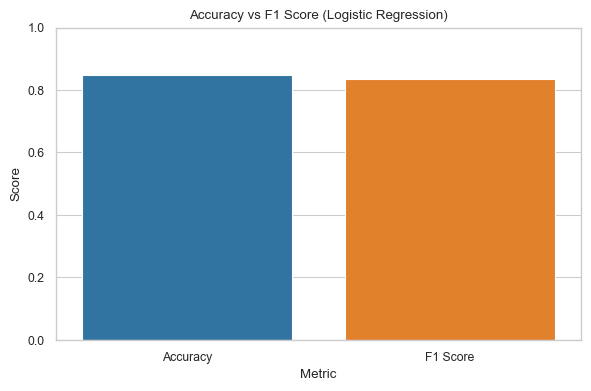

In [40]:
# Visualization - Accuracy vs F1 Score

# Apply seaborn style
sns.set_style("whitegrid")
sns.set_context("paper")

# Prepare DataFrame for plotting (using computed metrics)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Value': [acc_lr, f1_lr]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title("Accuracy vs F1 Score (Logistic Regression)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()
